# 业务预测

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from itertools import product
from datetime import datetime
import warnings
from statsmodels.stats.diagnostic import acorr_ljungbox
warnings.filterwarnings('ignore')


In [48]:
#设置默认字体
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [49]:
f=open('../数据/初步处理数据.csv')
data=pd.read_csv(f)
data['支付时间'] = pd.to_datetime(data['支付时间'])
data.head()

,金额,商品,支付时间,地点,商品大类,商品二级类
0,4.5,68g好丽友巧克力派2枚,2017-01-01 00:53:00,D,非饮料,饼干糕点
1,3.0,40g双汇玉米热狗肠,2017-01-01 01:33:00,A,非饮料,肉干/豆制品/蛋
2,5.0,48g好丽友薯愿香烤原味,2017-01-01 09:05:00,C,非饮料,膨化食品
3,3.0,600ml可口可乐,2017-01-01 09:41:00,B,饮料,碳酸饮料
4,4.5,营养快线,2017-01-01 09:41:00,B,饮料,乳制品


In [50]:
#分离地点数据
A_data=data[data['地点']=='A']
B_data=data[data['地点']=='B']
C_data=data[data['地点']=='C']
D_data=data[data['地点']=='D']
E_data=data[data['地点']=='E']

## 1. A地区

In [51]:
#处理A地区数据
Drink_A_data=A_data[A_data['商品大类']=='饮料']   #饮料数据
NonDrink_A_data=A_data[A_data['商品大类']=='非饮料']   #非饮料数据

#分别计算每天的销售额
Drink_A_sales=Drink_A_data.groupby([Drink_A_data['支付时间'].dt.month, Drink_A_data['支付时间'].dt.day])['金额'].count()
NonDrink_A_sales=NonDrink_A_data.groupby([NonDrink_A_data['支付时间'].dt.month, NonDrink_A_data['支付时间'].dt.day])['金额'].count()


### 1.1 饮料类

In [52]:
m=list(map(list,zip(*list(Drink_A_sales.index))))  #分离元组数据
n=[]  #存储时间
for i in range(len(Drink_A_sales)):
    n.append('2017/'+str(m[0][i])+'/'+str(m[1][i]))
Drink_A_data=pd.DataFrame(np.array(Drink_A_sales.values,dtype=np.float),index=n,columns=['money']) #变为DataFrame格式，索引为时间
Drink_A_data.index= pd.to_datetime(Drink_A_data.index)
Drink_A_data.head()

,money
2017-01-01,3.0
2017-01-02,5.0
2017-01-03,6.0
2017-01-04,1.0
2017-01-05,2.0


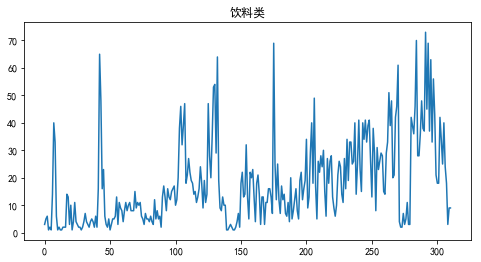

In [53]:
#绘制时序图
plt.subplots(figsize = (8,4))
plt.plot(Drink_A_data.values)
plt.title('饮料类')
plt.show()

In [54]:
#平稳性检测
print('饮料类：\n',adfuller(Drink_A_data.iloc[:,-1]))

饮料类：
 (-5.0030643530456045, 2.1885318446732984e-05, 2, 308, {'1%': -3.45176116018037, '5%': -2.870970093607691, '10%': -2.571794416006072}, 2284.8187693033306)


adf值小于1%的临界值，p值小于0.05，因此可认为是平稳序列

In [55]:
#白噪声检验
print('序列的白噪声检验结果：\n',acorr_ljungbox(Drink_A_data, lags= 1)) #返回统计量和 p 值

序列的白噪声检验结果：
 (array([119.61479047]), array([7.68188933e-28]))


p值小于0.05

In [56]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(Drink_A_data.money,order=(param[0],param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

# 输出最优模型
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('最优模型: ', best_model.summary())

最优模型:                                ARMA Model Results                              
Dep. Variable:                  money   No. Observations:                  311
Model:                     ARMA(1, 1)   Log Likelihood               -1204.725
Method:                       css-mle   S.D. of innovations             11.632
Date:                Thu, 29 Aug 2019   AIC                           2417.450
Time:                        12:47:44   BIC                           2432.409
Sample:                    01-01-2017   HQIC                          2423.430
                         - 12-31-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          17.5407      2.672      6.565      0.000      12.304      22.778
ar.L1.money     0.8622      0.044     19.772      0.000       0.777       0.948
ma.L1.money    -0.4328      0.081     -5.

In [57]:
#预测
predict_A= best_model.predict(0,len(Drink_A_data)+31)

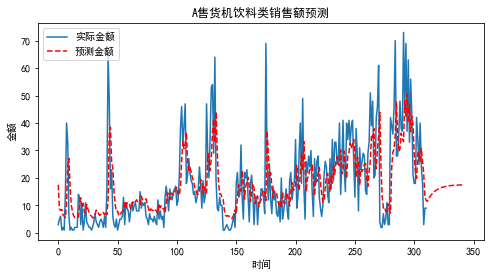

In [58]:
plt.figure(figsize=(8,4))
plt.plot(Drink_A_data.values,label='实际金额')
plt.plot(predict_A,c='r',ls='--', label='预测金额')
plt.legend()
plt.title('A售货机饮料类销售额预测')
plt.xlabel('时间')
plt.ylabel('金额')
plt.savefig('../图片/预测/A售货机饮料类.png')
plt.show()

In [59]:
#计算预测得出的2018年一月份的交易额
A_monthOne_drink=round(np.sum(predict_A[-31:]),3)
print('预测得到的A售货机2018年一月份饮料类商品的交易额为：',A_monthOne_drink)

预测得到的A售货机2018年一月份饮料类商品的交易额为： 505.914


### 1.2 非饮料类

In [60]:
m=list(map(list,zip(*list(NonDrink_A_sales.index))))  #分离元组数据
n=[]  #存储时间
for i in range(len(NonDrink_A_sales)):
    n.append('2017/'+str(m[0][i])+'/'+str(m[1][i]))
NonDrink_A_data=pd.DataFrame(np.array(NonDrink_A_sales.values,dtype=np.float),index=n,columns=['money']) #变为DataFrame格式，索引为时间
NonDrink_A_data.index= pd.to_datetime(NonDrink_A_data.index)
NonDrink_A_data.head()

,money
2017-01-01,4.0
2017-01-02,2.0
2017-01-03,4.0
2017-01-04,1.0
2017-01-05,1.0


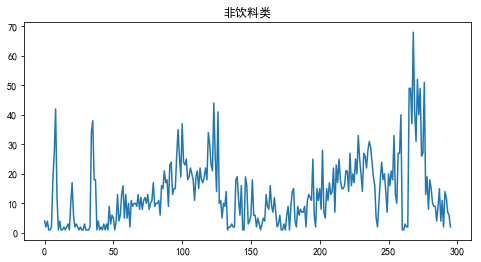

In [61]:
#绘制时序图
plt.subplots(figsize = (8,4))
plt.plot(NonDrink_A_data.values)
plt.title('非饮料类')
plt.show()

In [62]:
#平稳性检测
print('饮料类：\n',adfuller(NonDrink_A_data.iloc[:,-1]))

饮料类：
 (-4.807815242434597, 5.254434214157862e-05, 2, 293, {'1%': -3.452867117291862, '5%': -2.8714554160827745, '10%': -2.5720532321867466}, 1975.9760655487767)


adf值小于1%的临界值，p值小于0.05，因此可认为是平稳序列

In [63]:
print('序列的白噪声检验结果：\n',acorr_ljungbox(NonDrink_A_data, lags= 1)) #返回统计量和 p 值

序列的白噪声检验结果：
 (array([119.68713177]), array([7.40679204e-28]))


P值小于0.05

In [82]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(NonDrink_A_data.money,order=(param[0],param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

# 输出最优模型
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('最优模型: ', best_model.summary())

参数错误: (2, 2)
最优模型:                                ARMA Model Results                              
Dep. Variable:                  money   No. Observations:                  296
Model:                     ARMA(1, 1)   Log Likelihood               -1050.179
Method:                       css-mle   S.D. of innovations              8.397
Date:                Thu, 29 Aug 2019   AIC                           2108.359
Time:                        13:24:23   BIC                           2123.120
Sample:                    01-01-2017   HQIC                          2114.269
                         - 12-31-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.0610      1.999      6.534      0.000       9.143      16.979
ar.L1.money     0.8551      0.045     19.150      0.000       0.768       0.943
ma.L1.money    -0.3971      

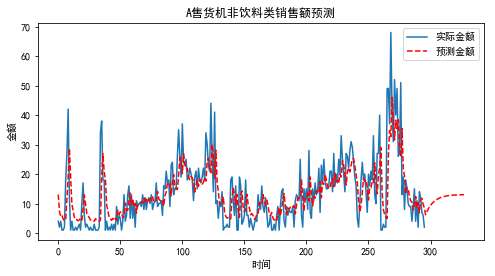

In [83]:
#预测
predict_A= best_model.predict(0,len(NonDrink_A_data)+31)
plt.figure(figsize=(8,4))
plt.plot(NonDrink_A_data.values,label='实际金额')
plt.plot(predict_A,c='r',ls='--', label='预测金额')
plt.legend()
plt.title('A售货机非饮料类销售额预测')
plt.xlabel('时间')
plt.ylabel('金额')
plt.savefig('../图片/预测/A售货机非饮料类.png')
plt.show()

In [84]:
#计算预测得出的2018年一月份的交易额
A_monthOne_NonDrink=round(np.sum(predict_A[-31:]),3)
print('预测得到的A售货机2018年一月份非饮料类商品的交易额为：',A_monthOne_NonDrink)

预测得到的A售货机2018年一月份非饮料类商品的交易额为： 364.674


## 2.B售货机

In [67]:
#处理B地区数据
Drink_B_data=B_data[B_data['商品大类']=='饮料']   #饮料数据
NonDrink_B_data=B_data[B_data['商品大类']=='非饮料']   #非饮料数据

#分别计算每天的销售额
Drink_B_sales=Drink_B_data.groupby([Drink_B_data['支付时间'].dt.month, Drink_B_data['支付时间'].dt.day])['金额'].count()
NonDrink_B_sales=NonDrink_B_data.groupby([NonDrink_B_data['支付时间'].dt.month, NonDrink_B_data['支付时间'].dt.day])['金额'].count()

### 2.1 饮料类

In [68]:
m=list(map(list,zip(*list(Drink_B_sales.index))))  #分离元组数据
n=[]  #存储时间
for i in range(len(Drink_B_sales)):
    n.append('2017/'+str(m[0][i])+'/'+str(m[1][i]))
Drink_B_data=pd.DataFrame(np.array(Drink_B_sales.values,dtype=np.float),index=n,columns=['money']) #变为DataFrame格式，索引为时间
Drink_B_data.index= pd.to_datetime(Drink_B_data.index)
Drink_B_data.head()

,money
2017-01-01,4.0
2017-01-02,5.0
2017-01-03,3.0
2017-01-04,1.0
2017-01-05,3.0


In [69]:
#平稳性检测
print('饮料类：\n',adfuller(Drink_B_data.iloc[:,-1]))

饮料类：
 (-4.725691323901815, 7.528212066295592e-05, 2, 314, {'1%': -3.4513486122290717, '5%': -2.870789013306053, '10%': -2.5716978530569192}, 2504.0565714282275)


adf值小于1%的临界值，p值小于0.05，因此可认为是平稳序列

In [70]:
#白噪声检验
print('序列的白噪声检验结果：\n',acorr_ljungbox(Drink_B_data, lags= 1)) #返回统计量和 p 值

序列的白噪声检验结果：
 (array([164.19650608]), array([1.37035781e-37]))


p值小于0.05

In [71]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(Drink_B_data.money,order=(param[0],param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model

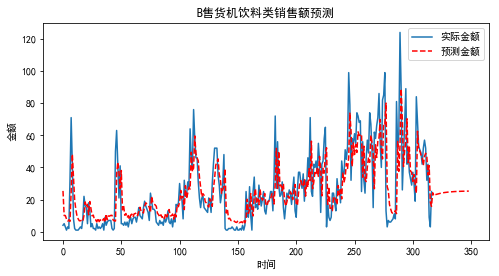

In [72]:
#预测
predict_B= best_model.predict(0,len(Drink_B_data)+31)
plt.figure(figsize=(8,4))
plt.plot(Drink_B_data.values,label='实际金额')
plt.plot(predict_B,c='r',ls='--', label='预测金额')
plt.legend()
plt.title('B售货机饮料类销售额预测')
plt.xlabel('时间')
plt.ylabel('金额')
plt.savefig('../图片/预测/B售货机饮料类.png')
plt.show()

In [73]:
#计算预测得出的2018年一月份的交易额
B_monthOne_drink=round(np.sum(predict_B[-31:]),3)
print('预测得到的A售货机2018年一月份饮料类商品的交易额为：',B_monthOne_drink)

预测得到的A售货机2018年一月份饮料类商品的交易额为： 761.044


### 2.2 非饮料类

In [74]:
m=list(map(list,zip(*list(NonDrink_B_sales.index))))  #分离元组数据
n=[]  #存储时间
for i in range(len(NonDrink_B_sales)):
    n.append('2017/'+str(m[0][i])+'/'+str(m[1][i]))
NonDrink_B_data=pd.DataFrame(np.array(NonDrink_B_sales.values,dtype=np.float),index=n,columns=['money']) #变为DataFrame格式，索引为时间
NonDrink_B_data.index= pd.to_datetime(NonDrink_B_data.index)
NonDrink_B_data.head()

,money
2017-01-02,3.0
2017-01-03,4.0
2017-01-04,3.0
2017-01-05,2.0
2017-01-06,1.0


In [75]:
#平稳性检测
print('饮料类：\n',adfuller(NonDrink_B_data.iloc[:,-1]))

饮料类：
 (-3.591770871074784, 0.005920313957909112, 5, 294, {'1%': -3.452789844280995, '5%': -2.871421512222641, '10%': -2.5720351510944512}, 1990.147655648036)


In [76]:
#白噪声检测
print('序列的白噪声检验结果：\n',acorr_ljungbox(NonDrink_B_data, lags= 1)) #返回统计量和 p 值

序列的白噪声检验结果：
 (array([119.71300913]), array([7.31079765e-28]))


参数错误: (2, 2)


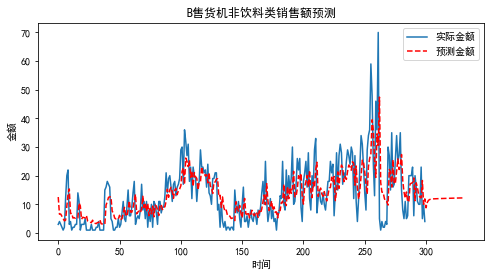

In [85]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(NonDrink_B_data.money,order=(param[0],param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        
#预测
predict_B= best_model.predict(0,len(NonDrink_B_data)+31)
plt.figure(figsize=(8,4))
plt.plot(NonDrink_B_data.values,label='实际金额')
plt.plot(predict_B,c='r',ls='--', label='预测金额')
plt.legend()
plt.title('B售货机非饮料类销售额预测')
plt.xlabel('时间')
plt.ylabel('金额')
plt.savefig('../图片/预测/B售货机非饮料类.png')
plt.show()

In [86]:
#计算预测得出的2018年一月份的交易额
B_monthOne_NonDrink=round(np.sum(predict_B[-31:]),3)
print('预测得到的A售货机2018年一月份非饮料类商品的交易额为：',B_monthOne_NonDrink)

预测得到的A售货机2018年一月份非饮料类商品的交易额为： 371.989


## 3. C、D、E三个地区

### 3.1 饮料类

In [100]:
place=['C','D','E']

place_data=[C_data,D_data,E_data] #将三个地区的数据组成列表

all_Drink_sales=[]
#首先检验平稳性和白噪声
for i in range(3):
    Drink_data=place_data[i][place_data[i]['商品大类']=='饮料']
    #销售额
    Drink_sales=Drink_data.groupby([Drink_data['支付时间'].dt.month, Drink_data['支付时间'].dt.day])['金额'].count()
    all_Drink_sales.append(Drink_sales)
        
    #平稳性检测
    print(place[i]+'地区饮料类平稳性：\n',adfuller(Drink_sales.values))
    #白噪声检验
    print(place[i]+'地区的白噪声检验结果：\n',acorr_ljungbox(Drink_sales.values, lags= 1)) #返回统计量和 p 值
    print()
    

C地区饮料类平稳性：
 (-3.578541314084007, 0.006184774953575471, 5, 318, {'1%': -3.451082300831733, '5%': -2.87067210822307, '10%': -2.5716355136268345}, 2569.4543622198435)
C地区的白噪声检验结果：
 (array([161.03710084]), array([6.71519656e-37]))

D地区饮料类平稳性：
 (-3.57363953914054, 0.006285447814411533, 7, 304, {'1%': -3.452045317832011, '5%': -2.871094805558846, '10%': -2.571860921485457}, 2212.486490141715)
D地区的白噪声检验结果：
 (array([139.8923577]), array([2.81030004e-32]))

E地区饮料类平稳性：
 (-3.39647672685067, 0.011079567730783132, 7, 317, {'1%': -3.451148243362826, '5%': -2.8707010565250752, '10%': -2.571650950153748}, 2975.915937897881)
E地区的白噪声检验结果：
 (array([171.66238609]), array([3.20696979e-39]))



**C,D两个地区的adf值均小于1%的边界值。E地区大于1%的边界值，但小于5%的边界值。且三个地区的P值均小于0.05，因此可认为是平稳序列。白噪声的检测，三个地区的随机概率均小于0.05，因此可认为是非白噪声序列**

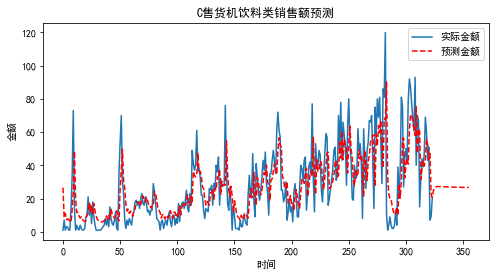

预测得到的C售货机2018年一月份饮料类商品的交易额为： 833.53



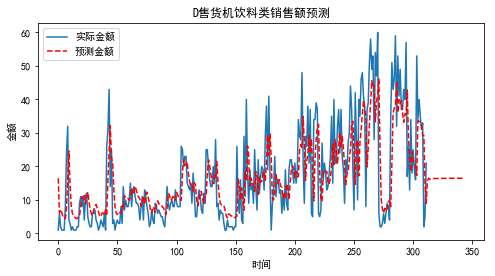

预测得到的D售货机2018年一月份饮料类商品的交易额为： 509.693



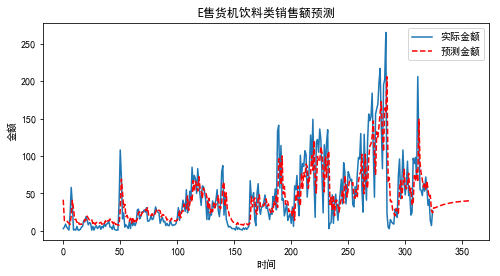

预测得到的E售货机2018年一月份饮料类商品的交易额为： 1143.407



In [101]:
monthOne_drink=[A_monthOne_drink, B_monthOne_drink] #将五个地区饮料类预测的数据放到一个列表中
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

#训练模型
for i in range(3):
    m=list(map(list,zip(*list(all_Drink_sales[i].index))))  #分离元组数据
    n=[]  #存储时间
    for j in range(len(all_Drink_sales[i])):
        n.append('2017/'+str(m[0][j])+'/'+str(m[1][j]))
    Drink_data=pd.DataFrame(np.array(all_Drink_sales[i].values,dtype=np.float),index=n,columns=['money']) #变为DataFrame格式，索引为时间
    Drink_data.index= pd.to_datetime(Drink_data.index)

    # 寻找最优ARMA模型参数，即best_aic最小
    best_aic = float("inf") # 正无穷
    for param in parameters_list:
        try:
            model = ARMA(Drink_data.money,order=(param[0],param[1])).fit()
        except ValueError:
            #print('参数错误:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
    #预测
    predict_place= best_model.predict(0,len(Drink_data)+31)
    plt.figure(figsize=(8,4))
    plt.plot(Drink_data.values,label='实际金额')
    plt.plot(predict_place,c='r',ls='--', label='预测金额')
    plt.legend()
    plt.title(place[i]+'售货机饮料类销售额预测')
    plt.xlabel('时间')
    plt.ylabel('金额')
    plt.savefig('../图片/预测/'+place[i]+'售货机饮料类.png')
    plt.show()
    #计算预测得出的2018年一月份的交易额
    place_monthOne_drink=round(np.sum(predict_place[-31:]),3)
    monthOne_drink.append(place_monthOne_drink)
    print('预测得到的'+place[i]+'售货机2018年一月份饮料类商品的交易额为：',place_monthOne_drink)
    print()

### 3.2 非饮料类

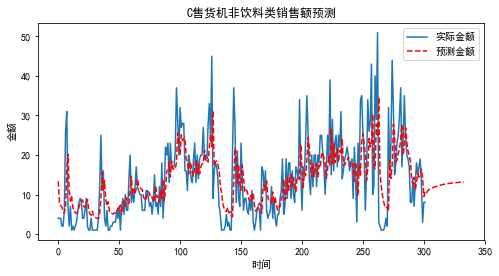

预测得到的C售货机2018年一月份非饮料类商品的交易额为： 386.571



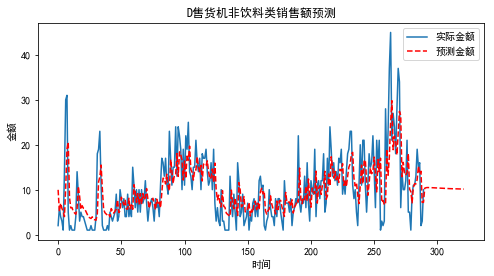

预测得到的D售货机2018年一月份非饮料类商品的交易额为： 318.972



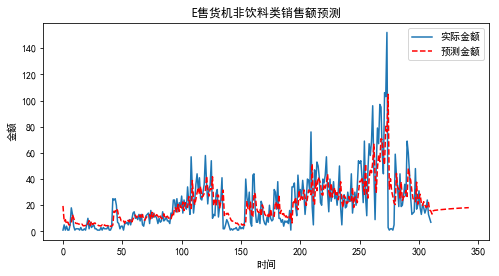

预测得到的E售货机2018年一月份非饮料类商品的交易额为： 533.927



In [102]:
monthOne_NonDrink=[A_monthOne_NonDrink, B_monthOne_NonDrink]
#首先检验平稳性和白噪声
for i in range(3):
    NonDrink_data=place_data[i][place_data[i]['商品大类']=='非饮料']
    #销售额
    NonDrink_sales=NonDrink_data.groupby([NonDrink_data['支付时间'].dt.month, NonDrink_data['支付时间'].dt.day])['金额'].count()
    
    m=list(map(list,zip(*list(NonDrink_sales.index))))  #分离元组数据
    n=[]  #存储时间
    for j in range(len(NonDrink_sales)):
        n.append('2017/'+str(m[0][j])+'/'+str(m[1][j]))
    NonDrink_data=pd.DataFrame(np.array(NonDrink_sales.values,dtype=np.float),index=n,columns=['money']) #变为DataFrame格式，索引为时间
    NonDrink_data.index= pd.to_datetime(NonDrink_data.index)

    # 寻找最优ARMA模型参数，即best_aic最小
    best_aic = float("inf") # 正无穷
    for param in parameters_list:
        try:
            model = ARMA(NonDrink_data.money,order=(param[0],param[1])).fit()
        except ValueError:
            #print('参数错误:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
    #预测
    predict_place= best_model.predict(0,len(NonDrink_data)+31)
    plt.figure(figsize=(8,4))
    plt.plot(NonDrink_data.values,label='实际金额')
    plt.plot(predict_place,c='r',ls='--', label='预测金额')
    plt.legend()
    plt.title(place[i]+'售货机非饮料类销售额预测')
    plt.xlabel('时间')
    plt.ylabel('金额')
    plt.savefig('../图片/预测/'+place[i]+'售货机非饮料类.png')
    plt.show()
    #计算预测得出的2018年一月份的交易额
    place_monthOne_NonDrink=round(np.sum(predict_place[-31:]),3)
    monthOne_NonDrink.append(place_monthOne_NonDrink)
    print('预测得到的'+place[i]+'售货机2018年一月份非饮料类商品的交易额为：',place_monthOne_NonDrink)
    print()


**依据判据标准，C地区符合平稳性序列，且非白噪声序列。D和E地区非白噪声序列，但两个地区的数据是非平稳性序列**

In [103]:
#现在有的数据：预测得到的饮料类金额monthOne_drink和非饮料类金额monthOne_NonDrink
place=['A','B','C','D','E']
predict_data=pd.DataFrame(np.array([monthOne_drink,monthOne_NonDrink]),index=['饮料类销售额','非饮料类销售额'],columns=place)
predict_data

,A,B,C,D,E
饮料类销售额,505.914,761.044,833.530,509.693,1143.407
非饮料类销售额,364.674,371.989,386.571,318.972,533.927
